In [1]:
import pandas as pd
import CococoNet_reader
import itertools
import numpy as np
import Name_resolver
import warnings
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import seaborn as sns

In [2]:
def Calculate_Score_list_for_thresholding(Species_1 = 'rice'): ### THIS IS TOMATO SPECIFIC
    

    import pandas as pd
    import CococoNet_reader
    import Name_resolver

    Species_2 = 'tomato'
    #Get Species Names in Common form 
    common_name_1 = Name_resolver.species_name_resolver(Species_1,'common')
    common_name_2 = 'tomato'


    matrix_of_locations = pd.read_csv('/data/passala/git/Coexpressalog_Method_Development/Cross_all_species/map_of_tomato_locations.csv', index_col= 0)#List of cross species maps
    current_location = matrix_of_locations["tomato"][common_name_1] #get string for map

    cross_species_n_m_genes = pd.read_csv('/data/passala/git/Solanum_SV_Pan_Genome/Jack_prickles/arabidopsis_tomato_added_LOG8.csv')

    if current_location.index('tomato') == 30:
        cross_species_n_m_genes = cross_species_n_m_genes.rename(columns = {'sp1_gene':'tomato','sp2_gene':common_name_1})
    else:
        cross_species_n_m_genes = cross_species_n_m_genes.rename(columns = {'sp1_gene':common_name_1,'sp2_gene':"tomato"})
        

    ### Get one to ones
    cross_species_map_one_to_one = cross_species_n_m_genes.drop_duplicates(subset=common_name_1, keep= False,)
    cross_species_map_one_to_one = cross_species_map_one_to_one.drop_duplicates(subset= common_name_2, keep= False)

    ## Convert to Dictionary
    dictionary_mapper_one_to_two = cross_species_map_one_to_one.set_index(common_name_1).to_dict()[common_name_2]
    dictionary_mapper_dos_to_uno = cross_species_map_one_to_one.set_index(common_name_2).to_dict()[common_name_1]

    ## Read In Cococonets 
    coconet_species_one = CococoNet_reader.read_cococonet(common_name_1)
    coconet_species_two = CococoNet_reader.read_cococonet(common_name_2)

    cross_species_n_m_genes['Group ID'] = 'Unassigned'
    

    ## Assign Genes to Groups
    id_indexer = 0
    for gene_pair in cross_species_n_m_genes.iterrows():
        
        if gene_pair[1]['Group ID'] == 'Unassigned':
            current_species_1_gene = gene_pair[1][common_name_1]
            current_species_2_gene = gene_pair[1][common_name_2]
            cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_1] == current_species_1_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer
            cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_2] == current_species_2_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer

            all_labeled_groups = cross_species_n_m_genes.loc[cross_species_n_m_genes['Group ID'] == id_indexer]

            all_labeled_groups_species_1_genes = all_labeled_groups[common_name_1].to_list()
            all_labeled_groups_species_2_genes = all_labeled_groups[common_name_2].to_list()

            cross_species_n_m_genes['Group ID'].loc[cross_species_n_m_genes[common_name_1].isin(all_labeled_groups_species_1_genes)] = id_indexer
            cross_species_n_m_genes['Group ID'].loc[cross_species_n_m_genes[common_name_2].isin(all_labeled_groups_species_2_genes)] = id_indexer

            id_indexer += 1



    #Identify Pairs for evaluation
    all_pairs_to_evaluate_for_functional_conservation = pd.DataFrame(columns = [common_name_1,common_name_2,'Group Number'])
    for group_number in list(set(cross_species_n_m_genes['Group ID'].to_list())):
        current_gene_map = cross_species_n_m_genes.loc[cross_species_n_m_genes['Group ID'] == group_number]
        list_of_species_1_genes_in_group = list(set(current_gene_map[common_name_1].to_list()))
        list_of_species_2_genes_in_group = list(set(current_gene_map[common_name_2].to_list()))
        all_combo_list_current_genes = itertools.product(list_of_species_1_genes_in_group,list_of_species_2_genes_in_group)
        all_combo_list_current_genes = list(map(list,all_combo_list_current_genes))
        current_list_of_pairs = pd.DataFrame(all_combo_list_current_genes,columns = [Species_1,Species_2])
        current_list_of_pairs['Group Number'] = group_number
        all_pairs_to_evaluate_for_functional_conservation = all_pairs_to_evaluate_for_functional_conservation.append(current_list_of_pairs)


    
    all_pairs_to_evaluate_for_functional_conservation['Species 1 Score'] = np.nan
    all_pairs_to_evaluate_for_functional_conservation['Species 2 Score'] = np.nan


    ## Trim cococonets to match


    trimmed_species_1_cococonet = coconet_species_one[coconet_species_one.columns.intersection(cross_species_n_m_genes[common_name_1].to_list())]
    trimmed_species_1_cococonet = trimmed_species_1_cococonet[trimmed_species_1_cococonet.index.isin(cross_species_n_m_genes[common_name_1].to_list())]
    double_species_1_trimmed_cococonet = trimmed_species_1_cococonet[trimmed_species_1_cococonet.columns.intersection(cross_species_map_one_to_one[common_name_1].to_list())]
    double_species_1_trimmed_cococonet = double_species_1_trimmed_cococonet.replace(1,0)

    trimmed_species_2_cococonet = coconet_species_two[coconet_species_two.columns.intersection(cross_species_n_m_genes[common_name_2].to_list())]
    trimmed_species_2_cococonet = trimmed_species_2_cococonet[trimmed_species_2_cococonet.index.isin(cross_species_n_m_genes[common_name_2].to_list())]
    double_species_2_trimmed_cococonet = trimmed_species_2_cococonet[trimmed_species_2_cococonet.columns.intersection(cross_species_map_one_to_one[common_name_2].to_list())]
    double_species_2_trimmed_cococonet = double_species_2_trimmed_cococonet.replace(1,0)


    ## Rank
    species_1_cococonet_ranked = trimmed_species_1_cococonet.rank()
    species_2_cococonet_ranked = trimmed_species_2_cococonet.rank()

    #Do top 10 Genes
    top_10_species_1_genes = np.array(
        [double_species_1_trimmed_cococonet.T[c].nlargest(10).index.values for c in double_species_1_trimmed_cococonet.T]
    )  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
    top_10_species_1_genes_dataframe = pd.DataFrame(
        data=top_10_species_1_genes,
        index=double_species_1_trimmed_cococonet.index,
        columns=[
            "One",
            "Two",
            "Three",
            "Four",
            "Five",
            "Six",
            "Seven",
            "Eight",
            "Nine",
            "Ten",
        ],
    )

    #Convert 
    top_10_species_1_genes_as_species_2 = top_10_species_1_genes_dataframe.replace(to_replace=dictionary_mapper_one_to_two)

    # Get genes for checking 
    have_species_1_pairs = all_pairs_to_evaluate_for_functional_conservation.loc[all_pairs_to_evaluate_for_functional_conservation[common_name_1].isin(top_10_species_1_genes_as_species_2.index)]
    trimmed_all_gene_pairs_for_fc = have_species_1_pairs.loc[have_species_1_pairs[common_name_2].isin(trimmed_species_2_cococonet.index)]
    trimmed_all_gene_pairs_for_fc = trimmed_all_gene_pairs_for_fc.reset_index(drop = True)

    # Get values in species 2 
    for two_genes in trimmed_all_gene_pairs_for_fc.iterrows():
        current_species_1_gene = two_genes[1][common_name_1]
        current_species_2_gene = two_genes[1][common_name_2]
        finger_print_genes = top_10_species_1_genes_as_species_2.loc[current_species_1_gene].to_list()
        gene_ranks_in_species_2 = species_2_cococonet_ranked.loc[species_2_cococonet_ranked.index.isin(finger_print_genes), current_species_2_gene]
        avg_rank_in_species_2 = gene_ranks_in_species_2.mean()
        index_from_pairs = two_genes[0]
        trimmed_all_gene_pairs_for_fc.at[index_from_pairs, 'Species 1 Score'] = avg_rank_in_species_2

    #Repeat for Species 2 

    top_10_species_2_genes = np.array(
        [double_species_2_trimmed_cococonet.T[c].nlargest(10).index.values for c in double_species_2_trimmed_cococonet.T]
    )  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
    top_10_species_2_genes_dataframe = pd.DataFrame(
        data=top_10_species_2_genes,
        index=double_species_2_trimmed_cococonet.index,
        columns=[
            "One",
            "Two",
            "Three",
            "Four",
            "Five",
            "Six",
            "Seven",
            "Eight",
            "Nine",
            "Ten",
        ],
    )
    

    #convert 
    top_10_species_2_genes_as_species_1 = top_10_species_2_genes_dataframe.replace(to_replace=dictionary_mapper_dos_to_uno)


    # Get values in species 1 
    for two_genes in trimmed_all_gene_pairs_for_fc.iterrows():
        current_species_1_gene = two_genes[1][common_name_1]
        current_species_2_gene = two_genes[1][common_name_2]
        finger_print_genes = top_10_species_2_genes_as_species_1.loc[current_species_2_gene].to_list()
        gene_ranks_in_species_1 = species_1_cococonet_ranked.loc[species_1_cococonet_ranked.index.isin(finger_print_genes), current_species_1_gene]
        avg_rank_in_species_1 = gene_ranks_in_species_1.mean()
        index_from_pairs = two_genes[0]
        trimmed_all_gene_pairs_for_fc.loc[index_from_pairs, 'Species 2 Score'] = avg_rank_in_species_1
    
    #Caluclate Divisors 
    Number_of_species_1_genes = len(top_10_species_1_genes_as_species_2)
    Number_of_species_2_genes = len(top_10_species_2_genes_as_species_1)


    species_1_score_divisor = Number_of_species_2_genes - 4.5
    species_2_score_divisor = Number_of_species_1_genes-4.5

    #Divide and Average 
    trimmed_all_gene_pairs_for_fc['Species 1 Score'] = trimmed_all_gene_pairs_for_fc['Species 1 Score']/species_1_score_divisor
    trimmed_all_gene_pairs_for_fc['Species 2 Score'] = trimmed_all_gene_pairs_for_fc['Species 2 Score']/species_2_score_divisor
    trimmed_all_gene_pairs_for_fc['Total Score'] = trimmed_all_gene_pairs_for_fc[['Species 1 Score','Species 2 Score']].mean(axis = 1)
    
    return trimmed_all_gene_pairs_for_fc
    

In [3]:
def Threshold_and_generate_coexpressalog_list(trimmed_all_gene_pairs_for_fc, single_pair_junk_threshold = .8, many_to_many_junk_threshold = .85,difference_between_many_to_drop = .03):
    
    
    list_of_true_pairs = []
    list_of_genes_to_average_and_set_to_be_equal = []


    common_name_1 = trimmed_all_gene_pairs_for_fc.columns[0]
    common_name_2 = trimmed_all_gene_pairs_for_fc.columns[1]

    for current_group in list(set(trimmed_all_gene_pairs_for_fc['Group Number'].to_list())):
        dataframe_of_group = trimmed_all_gene_pairs_for_fc.loc[trimmed_all_gene_pairs_for_fc['Group Number'] == current_group]
        dataframe_of_group = dataframe_of_group[[common_name_1,common_name_2,'Total Score']]
        wide_format = dataframe_of_group.pivot(index = common_name_1,columns= common_name_2,values= 'Total Score')
        if (wide_format<single_pair_junk_threshold).all(axis = None):
            continue
        elif wide_format.shape ==(0,0):
            continue
        elif wide_format.shape == (1,1): # Group is 1 to 1, retain Format: Arabidopsis then Maize
            one_true_pair = [wide_format.index.item(),wide_format.columns.item()]
            list_of_true_pairs.append(one_true_pair)
        elif len(wide_format)>1 and len(wide_format.columns) ==1:
            one_true_pair = [wide_format.idxmax(axis =0).item(),wide_format.columns.item()]
            list_of_true_pairs.append(one_true_pair)
        elif len(wide_format) == 1 and len(wide_format.columns)>1:
            one_true_pair = [wide_format.index.item(), wide_format.idxmax(axis = 1).item()]
            list_of_true_pairs.append(one_true_pair)
        else:

            #Drop Low Quality Columns and Rows
            cols_to_drop = wide_format.columns[wide_format.max()<many_to_many_junk_threshold]
            wide_format = wide_format.drop(columns= cols_to_drop)
            rows_to_drop = wide_format.index[wide_format.max(axis = 1)<many_to_many_junk_threshold]
            wide_format = wide_format.drop(index= rows_to_drop)
            if (wide_format<single_pair_junk_threshold).all(axis = None):
                continue
            elif wide_format.shape ==(0,0):
                continue
            elif wide_format.shape == (1,1): # Group is 1 to 1, retain Format: Arabidopsis then Maize
                one_true_pair = [wide_format.index.item(),wide_format.columns.item()]
                list_of_true_pairs.append(one_true_pair)
            elif len(wide_format)>1 and len(wide_format.columns) ==1:
                one_true_pair = [wide_format.idxmax(axis =0).item(),wide_format.columns.item()]
                list_of_true_pairs.append(one_true_pair)
            elif len(wide_format) == 1 and len(wide_format.columns)>1:
                one_true_pair = [wide_format.index.item(), wide_format.idxmax(axis = 1).item()]
                list_of_true_pairs.append(one_true_pair)
            elif (wide_format>.9).all(axis = None):
                ### Put in retention code here
                both_gene_lists_to_average = [wide_format.index.to_list(), wide_format.columns.to_list()]
                list_of_genes_to_average_and_set_to_be_equal.append(both_gene_lists_to_average)
                
            else:
                for cur_row in wide_format.iterrows():
                    cur_row_max = cur_row[1].max()
                    cur_row[1][cur_row[1]< cur_row_max - difference_between_many_to_drop] = np.nan
                    wide_format.loc[cur_row[0]] = cur_row[1]
                wide_format = wide_format.dropna(axis = 1, how = 'all')
                for cur_col in wide_format.columns:
                    cur_col_max = wide_format[cur_col].max()
                    wide_format[cur_col].loc[wide_format[cur_col]< cur_col_max-difference_between_many_to_drop] = np.nan
                wide_format = wide_format.dropna(axis = 0, how = 'all')
                col_count = wide_format.count() == 1
                wide_format = wide_format.loc[:,col_count]
                row_count = wide_format.count(axis = 1) ==1 
                wide_format = wide_format.loc[row_count,:]
                wide_format = wide_format.dropna(axis = 1, how = 'all')
                wide_format = wide_format.dropna(axis = 0, how = 'all')
                for label,content in wide_format.items():
                    cur_species_2_label = label
                    cur_species_1_label = content.idxmax()
                    if type(cur_species_1_label) == str:
                        one_true_pair = [cur_species_1_label,cur_species_2_label]
                        list_of_true_pairs.append(one_true_pair)


    true_pair_dataframe = pd.DataFrame(columns= [f'{common_name_1} gene',f'{common_name_2} gene'], data = list_of_true_pairs)
    true_pair_dataframe = true_pair_dataframe.drop_duplicates(subset = f'{common_name_1} gene')
    true_pair_dataframe = true_pair_dataframe.drop_duplicates(subset = f'{common_name_2} gene')
    
    return true_pair_dataframe
                

In [4]:
# tomato_cococonet_full = CococoNet_reader.read_cococonet('tomato')
# tomato_cococonet_full

In [5]:
score_list = Calculate_Score_list_for_thresholding('arabidopsis')

/tmp/ipykernel_319682/4286589746.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_1] == current_species_1_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer
/tmp/ipykernel_319682/4286589746.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_2] == current_species_2_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer
/tmp/ipykernel_319682/4286589746.py:55: SettingWithCopyWarning: 
A value is trying to be set on a co

In [6]:
log_family = score_list.loc[score_list['Group Number'] == 10740]

In [7]:
log_family.head()

,arabidopsis,tomato,Group Number,Species 1 Score,Species 2 Score,Total Score
13148,AT5G11950,LOG7,10740,0.767068,0.776883,0.771976
13149,AT5G11950,TLOG1,10740,0.549261,0.449642,0.499451
13150,AT5G11950,LOC101252798,10740,0.731032,0.904012,0.817522
13151,AT5G11950,LOC101246083,10740,0.608251,0.557274,0.582763
13152,AT5G11950,LOG6,10740,0.651014,0.566282,0.608648


In [20]:
arab_results = log_family.pivot(columns = 'arabidopsis', index = 'tomato', values = 'Total Score')
arab_results

arabidopsis,AT2G28305,AT2G37210,AT3G53450,AT4G35190,AT5G03270,AT5G06300,AT5G11950
tomato,,,,,,,
LOC101244985,0.513930,0.467639,0.616775,0.643171,0.397864,0.737256,0.585724
LOC101246083,0.712351,0.640678,0.437578,0.297390,0.676373,0.334278,0.582763
LOC101252798,0.498379,0.725286,0.898226,0.712142,0.472661,0.759926,0.817522
LOC101262778,0.900878,0.407773,0.316145,0.328408,0.564188,0.433204,0.654847
LOG6,0.813256,0.512292,0.347010,0.244052,0.654553,0.297597,0.608648
LOG7,0.526937,0.688170,0.853357,0.637217,0.505542,0.663119,0.771976
LOG8,0.936436,0.340658,0.272135,0.224279,0.644157,0.317697,0.591024
TLOG1,0.779032,0.337025,0.563769,0.712650,0.442870,0.793933,0.499451


In [21]:
arab_results = arab_results.rename(columns = {'AT2G28305':'Log1'})

In [11]:
arab_results = arab_results.replace(1,0)
linkage = hc.linkage(arab_results, method = 'average')

In [13]:
linkage

array([[ 2.        ,  5.        ,  0.14949049,  2.        ],
       [ 1.        ,  4.        ,  0.20050972,  2.        ],
       [ 3.        ,  6.        ,  0.20581266,  2.        ],
       [ 9.        , 10.        ,  0.31110411,  4.        ],
       [ 0.        ,  7.        ,  0.32811186,  2.        ],
       [ 8.        , 12.        ,  0.53272648,  4.        ],
       [11.        , 13.        ,  0.82224279,  8.        ]])

<AxesSubplot:xlabel='arabidopsis', ylabel='tomato'>

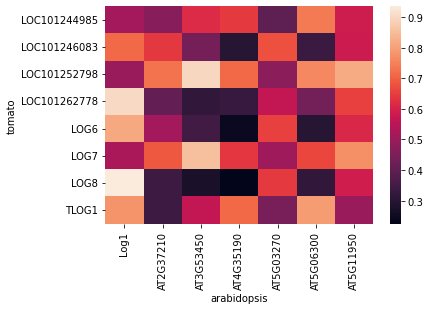

In [23]:
sns.heatmap(arab_results)

In [7]:
#arab_results.to_csv('/data/passala/git/Solanum_SV_Pan_Genome/Jack_prickles/arabi_Results.csv')
arab_results = pd.read_csv('/data/passala/git/Solanum_SV_Pan_Genome/Jack_prickles/arabi_Results.csv', index_col=0)

In [8]:
arab_results

,Log1,AT2G37210,AT3G53450,AT4G35190,AT5G03270,AT5G06300,AT5G11950
tomato,,,,,,,
LOC101244985,0.513930,0.467639,0.616775,0.643171,0.397864,0.737256,0.585724
LOC101246083,0.712351,0.640678,0.437578,0.297390,0.676373,0.334278,0.582763
LOC101252798,0.498379,0.725286,0.898226,0.712142,0.472661,0.759926,0.817522
LOC101262778,0.900878,0.407773,0.316145,0.328408,0.564188,0.433204,0.654847
LOG6,0.813256,0.512292,0.347010,0.244052,0.654553,0.297597,0.608648
LOG7,0.526937,0.688170,0.853357,0.637217,0.505542,0.663119,0.771976
LOG8,0.936436,0.340658,0.272135,0.224279,0.644157,0.317697,0.591024
TLOG1,0.779032,0.337025,0.563769,0.712650,0.442870,0.793933,0.499451


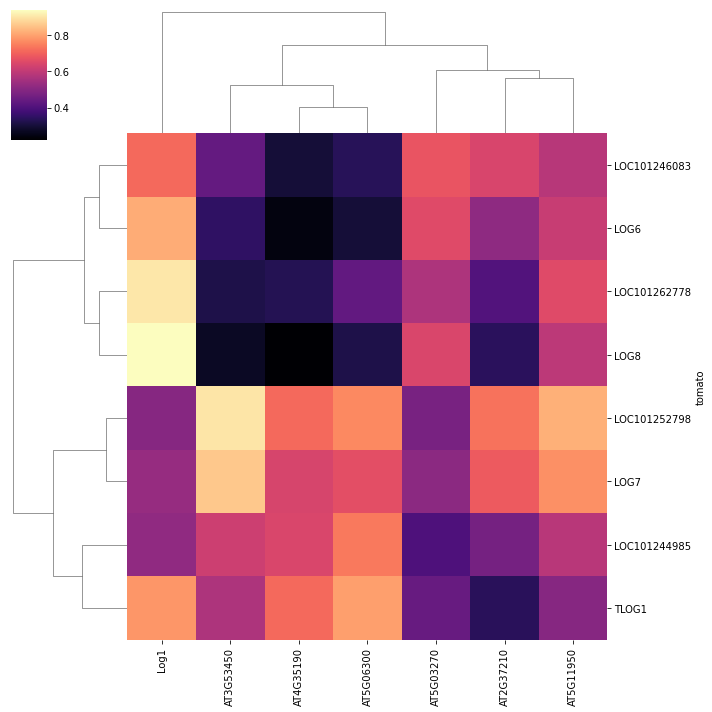

In [15]:
fig = sns.clustermap(arab_results,cmap = 'magma')
row_order = fig.dendrogram_row.reordered_ind
column_order = fig.dendrogram_col.reordered_ind
# ax.tick_params(axis='x', labelsize = 14)

In [16]:
column_order

[0, 2, 3, 5, 4, 1, 6]

In [17]:
row_order

[1, 4, 3, 6, 2, 5, 0, 7]

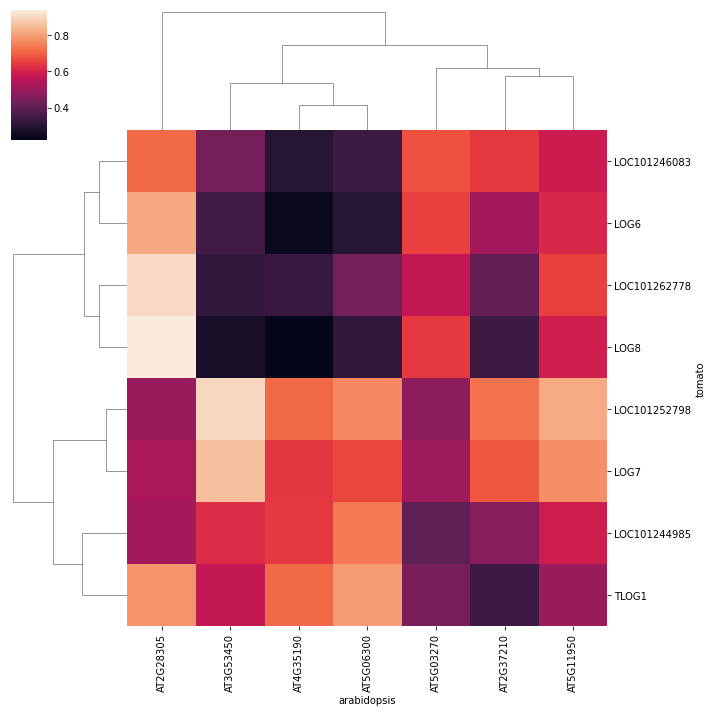

In [16]:
fig = sns.clustermap(arab_results, row_linkage=linkage )
# ax.tick_params(axis='x', labelsize = 14)
# ax.tick_params(axis='y', labelsize = 14)


In [7]:
rice_cococonet = CococoNet_reader.read_cococonet('rice')

In [13]:
rice_cococonet

,Os01g0100100,Os01g0100200,Os01g0100300,Os01g0100400,Os01g0100466,Os01g0100500,Os01g0100600,Os01g0100650,Os01g0100700,Os01g0100800,...,CAA33921,CAA33922,EPlORYSAT000373786,CAA33923,CAA33928,CAA33925,ENSRNA050013646,CAA33926,EPlORYSAT000373848,CAA33927
Os01g0100100,1.000000,0.415044,0.480129,0.954701,0.448483,0.998227,0.995926,0.198254,0.940504,0.981818,...,0.382719,0.425544,0.470139,0.504815,0.409516,0.454757,0.614028,0.421163,0.614028,0.437491
Os01g0100200,0.415044,1.000000,0.475633,0.752125,0.390407,0.441919,0.234515,0.153863,0.540154,0.122671,...,0.356485,0.404344,0.474192,0.647188,0.664977,0.381620,0.614028,0.346238,0.614028,0.476471
Os01g0100300,0.480129,0.475633,1.000000,0.472164,0.491006,0.478127,0.477430,0.492454,0.475249,0.478270,...,0.482379,0.493690,0.494493,0.476882,0.506376,0.494493,0.614028,0.483356,0.614028,0.473212
Os01g0100400,0.954701,0.752125,0.472164,1.000000,0.467006,0.994425,0.922651,0.235191,0.979149,0.973359,...,0.401590,0.417485,0.472492,0.574758,0.499648,0.453827,0.614028,0.567841,0.614028,0.303638
Os01g0100466,0.448483,0.390407,0.491006,0.467006,1.000000,0.499860,0.479244,0.463978,0.468096,0.457304,...,0.561327,0.381993,0.485635,0.524495,0.430997,0.395004,0.614028,0.459460,0.614028,0.540134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAA33925,0.454757,0.381620,0.494493,0.453827,0.395004,0.466965,0.420893,0.401437,0.491166,0.443996,...,0.392821,0.405365,0.491993,0.433486,0.542915,1.000000,0.614028,0.406444,0.614028,0.410354
ENSRNA050013646,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,...,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,1.000000,0.614028,0.614028,0.614028
CAA33926,0.421163,0.346238,0.483356,0.567841,0.459460,0.545018,0.406758,0.329394,0.374544,0.497855,...,0.308608,0.453265,0.527565,0.408765,0.558342,0.406444,0.614028,1.000000,0.614028,0.519980
EPlORYSAT000373848,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,...,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,0.614028,1.000000,0.614028


In [14]:
rice_cococonet.loc[['Os04g0518800','Os02g0628000']]

,Os01g0100100,Os01g0100200,Os01g0100300,Os01g0100400,Os01g0100466,Os01g0100500,Os01g0100600,Os01g0100650,Os01g0100700,Os01g0100800,...,CAA33921,CAA33922,EPlORYSAT000373786,CAA33923,CAA33928,CAA33925,ENSRNA050013646,CAA33926,EPlORYSAT000373848,CAA33927
Os04g0518800,0.376785,0.457624,0.471988,0.908532,0.486238,0.718271,0.161405,0.273118,0.895107,0.565454,...,0.349292,0.452513,0.497246,0.424711,0.546805,0.413383,0.614028,0.428666,0.614028,0.441178


In [ ]:
rice_gene_list = ['Os04g0518800']

In [ ]:
tomato_genes_list = ['LOG8','LOC101262778','LOC101246083','LOG6','LOG7','TLOG1','LOC101252798']

In [ ]:
arabi_gene_list = ['AT2G37210',"AT3G53450","AT2G28305","AT5G06300","AT4G35190","AT5G03270","AT2G35990","AT5G11950"]

In [ ]:
test_list = [arabi_gene_list, tomato_genes_list]
combinations = [p for p in itertools.product(*test_list)]

In [ ]:
combo_df = pd.DataFrame(data = combinations, columns = ['arabi','tomato'])


In [ ]:
#combo_df.to_csv("/data/passala/git/Solanum_SV_Pan_Genome/Jack_prickles/temp_csv.csv",index = False)

In [ ]:
all_combo = itertools.permutations(tomato_genes_list,arabi_gene_list)

In [ ]:
tomato_cococonet_full.loc[['LOG8','LOC101262778','LOC101246083','LOG6','LOG7','TLOG1','LOC101252798']]

In [ ]:
matrix_of_locations = pd.read_csv('/data/passala/git/Coexpressalog_Method_Development/Cross_all_species/map_of_tomato_locations.csv', index_col= 0)#List of cross species maps
rice_tomato_table = Calculate_Score_list_for_thresholding('rice')
